In [1]:
# walk thru of steps found here: http://drivendata.co/blog/rinse-over-run-benchmark/

import pandas as pd
import os
import git
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

def get_git_root(path):

    git_repo = git.Repo(path, search_parent_directories=True)
    #git_root = git_repo.git.rev_parse("--show-toplevel")

    return git_repo.working_dir

In [2]:
# project directory is a bit different than what is specified in the URL above. 
# File structure based on DrivenData blog post: https://drivendata.github.io/cookiecutter-data-science/

top_level_git_dir = get_git_root(os.getcwd())
raw_data_dir = os.path.join(top_level_git_dir, "data", "raw")

train_csv_path = os.path.join(raw_data_dir, "train_values.csv")
test_csv_path = os.path.join(raw_data_dir, "test_values.csv")
train_labels_csv_path = os.path.join(raw_data_dir, "train_labels.csv")
submission_format_csv_path = os.path.join(raw_data_dir, "submission_format.csv")

train_df = pd.read_csv(train_csv_path, index_col = "row_id")
train_labels_df = pd.read_csv(train_labels_csv_path, index_col = "process_id")
test_df = pd.read_csv(test_csv_path, index_col = "row_id")
submission_format_df = pd.read_csv(submission_format_csv_path, index_col = "process_id")

/Users/greg.bolla/.local/share/virtualenvs/driven-data-rinse-over-run-w5STMFPe/lib/python3.6/site-packages/numpy/lib/arraysetops.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
train_df.dtypes

process_id                             int64
object_id                              int64
phase                                 object
timestamp                     datetime64[ns]
pipeline                              object
supply_flow                          float64
supply_pressure                      float64
return_temperature                   float64
return_conductivity                  float64
return_turbidity                     float64
return_flow                          float64
supply_pump                             bool
supply_pre_rinse                        bool
supply_caustic                          bool
return_caustic                          bool
supply_acid                             bool
return_acid                             bool
supply_clean_water                      bool
return_recovery_water                   bool
return_drain                            bool
object_low_level                        bool
tank_level_pre_rinse                 float64
tank_level

In [4]:
train_labels_df.head()

,final_rinse_total_turbidity_liter
process_id,
20001,4.318275e+06
20002,4.375286e+05
20003,4.271977e+05
20004,7.197830e+05
20005,4.133107e+05


In [5]:
# subset only in time period where we want to predict turbidity
target_time_df = train_df[train_df.target_time_period == True]

# can get a better idea by looking at one process
example_process_id = target_time_df.process_id.unique()[223] #20017
example_final_phase = target_time_df[target_time_df.process_id == example_process_id]

In [6]:
# manually calculate target to ensure it matches train_labels
example_final_phase = example_final_phase.assign(turbidity_calculated = \
   np.maximum(0, example_final_phase.return_flow) * example_final_phase.return_turbidity)

example_final_phase[["process_id", "phase", "process_id", "return_flow", "return_turbidity", "turbidity_calculated"]].tail()


,process_id,phase,process_id,return_flow,return_turbidity,turbidity_calculated
row_id,,,,,,
276108,20360,final_rinse,20360,7.233796,0.083189,0.601770
276109,20360,final_rinse,20360,7.233796,0.079572,0.575606
276110,20360,final_rinse,20360,7.233796,0.083189,0.601770
276111,20360,final_rinse,20360,7.233796,0.086806,0.627934
276112,20360,final_rinse,20360,7.233796,0.083189,0.601770


Text(0.5, 1.0, 'Turbidity in final phase for process_id 20360')

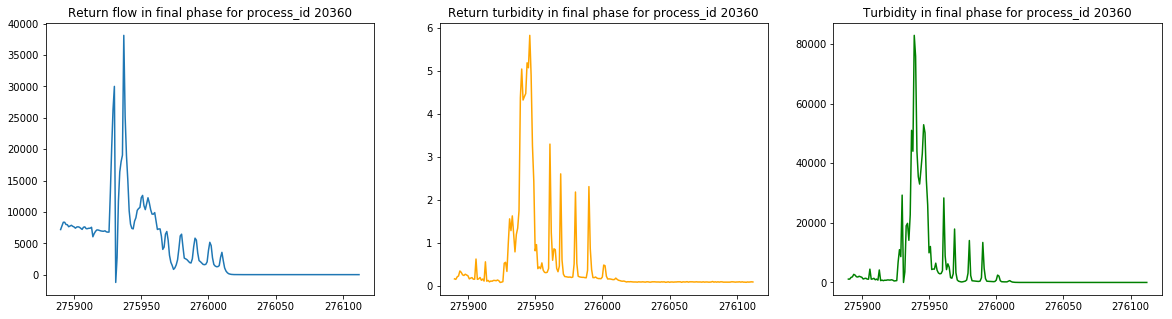

In [7]:
# plot the inputs to the target along with manually calculated target
figure, axis = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

axis[0].plot(example_final_phase.return_flow)
axis[0].set_title('Return flow in final phase for process_id {}'.format(example_process_id))

axis[1].plot(example_final_phase.return_turbidity, c='orange')
axis[1].set_title('Return turbidity in final phase for process_id {}'.format(example_process_id))

axis[2].plot(example_final_phase.turbidity_calculated, c='green')
axis[2].set_title('Turbidity in final phase for process_id {}'.format(example_process_id))

In [8]:
# check to see if calculated turbidity match train_labels from raw data
print("turbidity calculated = {}".format(example_final_phase.turbidity_calculated.sum()))
print("turbidity from data = {}".format(train_labels_df["final_rinse_total_turbidity_liter"].loc[example_process_id]))

turbidity calculated = 993958.8553579567
turbidity from data = 993958.8553579568


In [9]:
# drop final_rinse phase since there are any obs in test set with that phase
train_df = train_df[train_df.phase != "final_rinse"]

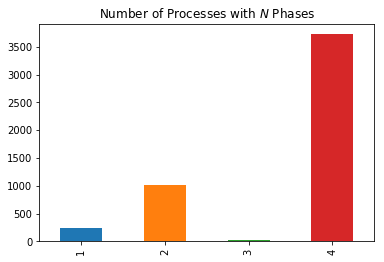

In [10]:
# since test set has: 
## - 10% of instances w/only 1 phase
## - 30% of instances w/only 2 phases
## - 30% of instances w/only 3 phases
## - 30% of instances w/only 4 phases

# want to replicate that distribution in training

train_df.groupby('process_id').phase.nunique().value_counts().sort_index().plot.bar()
plt.title("Number of Processes with $N$ Phases");

In [11]:
train_df['process_phase'] = train_df.process_id.astype(str) + "_" + train_df.phase.astype(str)
process_phases = train_df.process_phase.unique()

# randomly select 80% of unique process_phases to keep
rng = np.random.RandomState(2019)
to_keep = rng.choice(
    process_phases,
    size = np.int(len(process_phases) * 0.8),
    replace = False
)

train_df_limited = train_df[train_df.process_phase.isin(to_keep)]
# subset training labels to match only those incl. in train_df_limited
train_labels_df = train_labels_df.loc[train_df_limited.process_id.unique()]

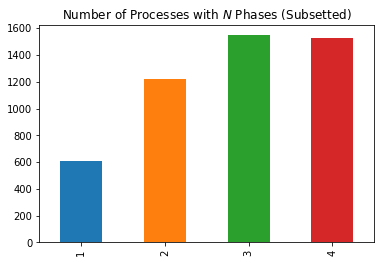

In [12]:
train_df_limited.groupby('process_id').phase.nunique().value_counts().sort_index().plot.bar()
plt.title("Number of Processes with $N$ Phases (Subsetted)");

In [13]:
train_df_limited.head()

,process_id,object_id,phase,timestamp,pipeline,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,...,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_caustic,tank_lsh_acid,tank_lsh_clean_water,tank_lsh_pre_rinse,target_time_period,process_phase
row_id,,,,,,,,,,,,,,,,,,,,,
0,20001,405,pre_rinse,2018-04-15 04:20:47,L4,8550.348,0.615451,18.044704,4.990765,0.177228,...,83.036750,73.03241,45.394646,44.340126,False,0.0,False,0.0,False,20001_pre_rinse
1,20001,405,pre_rinse,2018-04-15 04:20:49,L4,11364.294,0.654297,18.229168,3.749680,0.122975,...,83.015045,73.03241,45.394447,44.339380,False,0.0,False,0.0,False,20001_pre_rinse
2,20001,405,pre_rinse,2018-04-15 04:20:51,L4,12174.479,0.699870,18.395544,2.783954,0.387008,...,83.015045,73.03241,45.396280,44.336735,False,0.0,False,0.0,False,20001_pre_rinse
3,20001,405,pre_rinse,2018-04-15 04:20:53,L4,13436.776,0.761502,18.583622,1.769353,0.213397,...,83.036750,73.03241,45.401875,44.333110,False,0.0,False,0.0,False,20001_pre_rinse
4,20001,405,pre_rinse,2018-04-15 04:20:55,L4,13776.766,0.837240,18.627026,0.904020,0.148293,...,83.015045,73.03241,45.398197,44.334373,False,0.0,False,0.0,False,20001_pre_rinse


In [14]:
train_df_limited.groupby("process_id")["phase"].apply(lambda x: x.nunique()).head()

process_id
20001    4
20002    2
20003    3
20004    2
20005    1
Name: phase, dtype: int64

In [15]:
def prep_metadata(df):
    meta_df = df[["process_id", "pipeline"]].drop_duplicates().set_index("process_id")
    meta_df = pd.get_dummies(meta_df)
    
    if 'L12' not in meta_df.columns:
        meta_df['pipeline_L12'] = 0
        
    meta_df["num_phases"] = df.groupby("process_id")["phase"].apply(lambda x: x.nunique())
    return meta_df

prep_metadata(train_df_limited.tail(5000))

,pipeline_L1,pipeline_L2,pipeline_L4,pipeline_L7,pipeline_L9,pipeline_L12,num_phases
process_id,,,,,,,
27980,1,0,0,0,0,0,3
27982,0,0,1,0,0,0,4
27983,0,1,0,0,0,0,4
27987,0,0,1,0,0,0,4
27988,0,0,0,0,1,0,4
27989,0,0,0,1,0,0,3


In [16]:
ts_cols = [
    'process_id',
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid',
]

def prep_time_series_features(df, columns = None):
    
    if columns is None:
        columns = df.columns
        
    ts_df = df[ts_cols].set_index('process_id')
    
    # define fxn before calling in .agg to make col name more descriptive (in place of <lambda>)
    def last_five_mean(x):
        return x.tail(5).mean()
    
    ts_features_df = ts_df.groupby('process_id').agg(['min', 'max', 'mean', 'std', last_five_mean])
    
    return ts_features_df

In [17]:
def create_feature_matrix(df):
    
    metadata_df = prep_metadata(df)
    time_series_df = prep_time_series_features(df)
    
    dfs_to_concat = [metadata_df, time_series_df]
    
    feature_df = pd.concat(dfs_to_concat, axis=1)
    
    return feature_df

In [27]:
train_features_df = create_feature_matrix(train_df_limited)
train_features_df["num_phases"].head()

process_id
20001    4
20002    2
20003    3
20004    2
20005    1
Name: num_phases, dtype: int64

In [19]:
%%time
rand_forest = RandomForestRegressor(n_estimators = 1000, random_state=2019)
rand_forest.fit(train_features_df, np.ravel(train_labels_df))


CPU times: user 6min 6s, sys: 4.05 s, total: 6min 10s
Wall time: 6min 37s


In [20]:
test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])
test_features_df = create_feature_matrix(test_df)
test_features_df.head()

,pipeline_L1,pipeline_L10,pipeline_L11,pipeline_L2,pipeline_L3,pipeline_L4,pipeline_L6,pipeline_L7,pipeline_L8,pipeline_L9,...,"(tank_concentration_caustic, min)","(tank_concentration_caustic, max)","(tank_concentration_caustic, mean)","(tank_concentration_caustic, std)","(tank_concentration_caustic, last_five_mean)","(tank_concentration_acid, min)","(tank_concentration_acid, max)","(tank_concentration_acid, mean)","(tank_concentration_acid, std)","(tank_concentration_acid, last_five_mean)"
process_id,,,,,,,,,,,,,,,,,,,,,
20000,0,0,0,0,0,1,0,0,0,0,...,44.521880,46.734280,45.359978,0.263476,45.360349,44.753242,45.244890,45.070216,0.069214,45.050809
20006,0,0,0,0,0,0,1,0,0,0,...,44.463470,46.812943,45.265983,0.309268,45.244624,44.253990,47.871460,45.552704,0.902801,45.186858
20007,0,0,0,0,0,0,1,0,0,0,...,45.257053,45.813564,45.479250,0.098108,45.488373,43.918640,44.796196,44.505637,0.263041,44.244708
20009,0,0,0,0,0,1,0,0,0,0,...,44.548534,46.639267,45.179930,0.367397,44.965748,44.475380,45.165077,44.602441,0.247910,45.163842
20010,0,0,0,0,0,0,0,1,0,0,...,43.544760,47.820510,45.347678,0.439164,44.925080,44.013447,47.362960,44.911785,0.648652,44.414867


In [21]:
preds_array = rand_forest.predict(test_features_df)

In [22]:
assert np.all(test_features_df.index == submission_format_df.index), "index of submission doesn't match format"

In [23]:
example_submission = pd.DataFrame(data = preds_array,
                                 columns = submission_format_df.columns,
                                 index = submission_format_df.index)
example_submission.head()

,final_rinse_total_turbidity_liter
process_id,
20000,1.003440e+06
20006,1.262055e+06
20007,1.311577e+06
20009,1.793753e+06
20010,7.934597e+05


In [24]:
example_submission.to_csv(os.path.join(top_level_git_dir, "models", "example_submission.csv"))